In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

# index data
tokens = sorted(list(set(''.join(words))))
stoi = {x:i+1 for i,x in enumerate(tokens)}
stoi['.'] = 0
itos = {i:x for x,i in stoi.items()}

vocab_size = len(stoi)

In [26]:
# build the dataset

BLOCK_SIZE = 8 # how many characters to use to predict next character?
def build_dataset(words):
  X = []
  Y = []

  for word in words:
    # print(word)
    ctx = [0] * BLOCK_SIZE
    for c in word + '.':
      y = stoi[c]
      X.append(ctx)
      Y.append(y)
      # print(''.join(itos[i] for i in ctx), ' -> ', itos[y])
      ctx = ctx[1:] + [y]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [27]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
torch.manual_seed(42)

In [28]:
n_embed = 10 # character embedding dimenstions
n_hidden = 200 # num of neurons in the hidden layer
g = torch.Generator().manual_seed(12121212) # for repreducibility

model = Sequential([
    Embedding(vocab_size, n_embed),
    Flatten(),
    Linear(n_embed * BLOCK_SIZE, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
#     # all other layers: apply gain
#     for layer in layers[:-1]:
#         if isinstance(layer, Linear):
#             layer.weight *= 5/3

params = model.parameters()
print(sum(p.nelement() for p in params)) # num of params in network
for p in params:
    p.requires_grad = True

22097


In [29]:
# optimization
max_steps = 200_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # build mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # nll loss
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad
    for p in params:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # learning rate decay
    for p in params:
        p.data += -lr * p.grad
    
    # stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in params])

      0/ 200000: 3.5423
  10000/ 200000: 2.3569
  20000/ 200000: 2.5643
  30000/ 200000: 1.9939
  40000/ 200000: 2.3903
  50000/ 200000: 2.1886
  60000/ 200000: 2.0404
  70000/ 200000: 2.0652
  80000/ 200000: 2.0526
  90000/ 200000: 1.6401
 100000/ 200000: 1.9389
 110000/ 200000: 1.7450
 120000/ 200000: 1.7918
 130000/ 200000: 2.0308
 140000/ 200000: 1.9741
 150000/ 200000: 1.9397
 160000/ 200000: 1.7040
 170000/ 200000: 1.8006
 180000/ 200000: 1.6924
 190000/ 200000: 2.0086


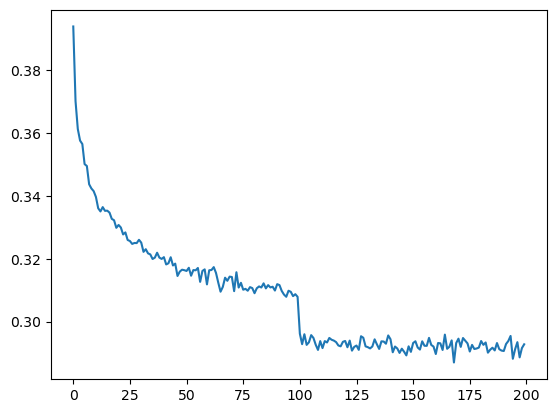

In [31]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [32]:
# put layers into eval mode (needed fro bathnorm especially)
for layer in model.layers:
    layer.training = False

In [33]:
# eval the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 1.9307094812393188
val 2.0324578285217285


In [34]:
# sample from the model
for _ in range(20):
    out = []
    ctx = [0] * BLOCK_SIZE # init with all [...]
    while True:
        logits = model(torch.tensor([ctx]))
        probs = F.softmax(logits, dim=1)
        # sample from the probability distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        ctx = ctx[1:] + [ix]
        out.append(ix)
        if ix == 0:
            # end of word
            break
    print(''.join(itos[i] for i in out))

melan.
lyri.
gwosxny.
arryn.
zakayah.
elson.
taion.
dayana.
haziyah.
hamilinse.
chann.
shaydan.
eba.
kakyli.
cash.
hamby.
dwacina.
horand.
malsenna.
fatzinit.
